In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
from time import time
random.seed(11)
%matplotlib inline
# sns.set()
# sns.reset_orig()

# Instructions

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

NOTE: 
- I've picked 2014, which is the latest available year.
- I'm going to use PCA (rather than GLRM) for feature reduction, just for practice

# Load and clean

In [2]:
results_df = pd.read_csv('results_2014.csv')
results_df.shape

(31984, 21)

In [3]:
results_df.head()

10k                name  division    25k gender  age  official bib  \
0  17.37  Yamamoto, Hiroyuki         8  47.67      M   47     85.25  W1   
1  32.58        Jeptoo, Rita         1  82.43      F   33    138.95  F1   
2  16.62   Van Dyk, Ernst F.         1  45.80      M   41     80.60  W2   
3  32.57        Dibaba, Mare         3  82.43      F   24    140.58  F2   
4  17.12      Hokinoue, Kota         2  46.37      M   40     81.23  W3   

   genderdiv  ctz   ...   overall  pace  state    30k     5k   half    20k  \
0          8  NaN   ...         8  3.27    NaN  59.18   8.02  39.72  37.65   
1          1  NaN   ...        21  5.30    NaN  99.33  16.22  69.47  65.83   
2          1  NaN   ...         1  3.08    NaN  56.45   7.75  38.03  36.10   
3          3  NaN   ...        27  5.37    NaN  99.33  16.20  69.47  65.83   
4          2  NaN   ...         2  3.10    NaN  57.03   8.02  38.60  36.58   

  country            city     40k  
0     JPN         Fukuoka   80.43  
1     KEN         Eldoret  132.10  
2     RSA           Paarl   76.10  
3     ETH            Shoa  132.95  
4     JPN  Nogata Fukuoka   76.72  

[5 rows x 21 columns]

In [4]:
# drop 'ctz' column, which is over 90% null:
results_df.drop('ctz', axis=1, inplace=True)

# fill the 10% or so missing 'state' values  with NA (presumably applies to foreign nationals):
results_df.state.fillna('NA', inplace=True)

# drop the one remaining row with a null (missing value for 'city'):
results_df.dropna(inplace=True) 

# convert gender to a boolean:
results_df.gender = (results_df.gender=='F').astype(int)

# deal with null time-marks, which are entered as "-", which types the minute intervals as objects
# since there are only about 400 missing values, we'll just drop the rows for now.
distances = ['5k', '20k', '25k', '30k', '35k', '40k', 'half']
for distance in distances:
    results_df = results_df[results_df[distance]!= '-']
    results_df[distance] = results_df[distance].astype(float)

results_df.isnull().sum().sum()

0

In [5]:
results_df.select_dtypes([int, float]).head()

division    25k  gender  age  official  genderdiv     35k  overall  pace  \
0         8  47.67       0   47     85.25          8   71.40        8  3.27   
1         1  82.43       1   33    138.95          1  116.37       21  5.30   
2         1  45.80       0   41     80.60          1   67.42        1  3.08   
3         3  82.43       1   24    140.58          3  116.37       27  5.37   
4         2  46.37       0   40     81.23          2   67.83        2  3.10   

     30k     5k   half    20k     40k  
0  59.18   8.02  39.72  37.65   80.43  
1  99.33  16.22  69.47  65.83  132.10  
2  56.45   7.75  38.03  36.10   76.10  
3  99.33  16.20  69.47  65.83  132.95  
4  57.03   8.02  38.60  36.58   76.72

# Feature Reduction

In [6]:
from sklearn.preprocessing import StandardScaler, Normalizer

scaled_df = results_df.select_dtypes([int, float]).copy()
num_cols = list(results_df.select_dtypes(float).columns) + ['age']
ordinal_cols = ['overall','division','genderdiv'] # these ordinals represent runner placement in the titular category

scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols])
scaled_df[ordinal_cols] = Normalizer().fit_transform(scaled_df[ordinal_cols]) 

In [7]:
scaled_df.head()

division       25k  gender       age  official  genderdiv       35k  \
0  0.577350 -3.358935       0  0.408472 -3.081619   0.577350 -3.056069   
1  0.047511 -2.000078       1 -0.830584 -2.025722   0.047511 -1.953535   
2  0.577350 -3.432038       0 -0.122552 -3.173052   0.577350 -3.153647   
3  0.109764 -2.000078       1 -1.627120 -1.993672   0.109764 -1.953535   
4  0.577350 -3.409755       0 -0.211056 -3.160664   0.577350 -3.143595   

    overall      pace       30k        5k      half       20k       40k  
0  0.577350 -3.076354 -3.183272 -4.187851 -3.519750 -3.531105 -3.073055  
1  0.997740 -2.029806 -1.962901 -2.243329 -2.055258 -2.060861 -1.998584  
2  0.577350 -3.174307 -3.266251 -4.251878 -3.602943 -3.611973 -3.163097  
3  0.987878 -1.993718 -1.962901 -2.248072 -2.055258 -2.060861 -1.980908  
4  0.577350 -3.163996 -3.248622 -4.187851 -3.574884 -3.586930 -3.150204

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_array = pca.fit_transform(scaled_df)
print(pca.explained_variance_ratio_)

[0.85606077 0.09697828]


Looks like PCA was fairly effective here - it captured about 95% of the total variance.  This isn't surprising, since half of the features are timestamps, which are highly correlated (if you have a lowwer-than-average time at 25K, you'll have a lower-than-average time at 30K too).

For the sake of interpretability, let's see what these features are made of:

In [9]:
from scipy.stats import pearsonr
pca
corrs_1 = []
corrs_2 = []
for col in scaled_df.columns:
    corrs_1.append((col, round(pearsonr(scaled_df[col], pca_array[:,0])[0], 3)))
    corrs_2.append((col, round(pearsonr(scaled_df[col], pca_array[:,1])[0], 3)))
corrs_1 = sorted(corrs_1, key=lambda x: -abs(x[1]))
corrs_2 = sorted(corrs_2, key=lambda x: -abs(x[1]))

print("Correlations (r) with first PCA component:")
for tup in corrs_1:
    print(tup[0]+":", tup[1])
print("\nCorrelations (r) with second PCA component:")
for tup in corrs_2:
    print(tup[0]+":", tup[1])

Correlations (r) with first PCA component:
30k: 0.996
25k: 0.994
35k: 0.994
half: 0.991
20k: 0.99
40k: 0.988
official: 0.986
pace: 0.986
5k: 0.952
overall: 0.477
division: -0.363
gender: 0.249
genderdiv: -0.224
age: 0.183

Correlations (r) with second PCA component:
age: 0.98
division: -0.592
gender: -0.332
genderdiv: 0.318
overall: -0.079
25k: -0.025
30k: -0.025
35k: -0.022
20k: -0.019
5k: -0.018
half: -0.018
40k: -0.017
official: -0.009
pace: -0.009


It seems that the first principal component is the runner's time (composite of the time at each checkpoint, and the official final time). The second principal component is basically age.  Age is a large determiner of placement in each of the divisions, since the divisions are basically groups of similarly-aged participants.

Henceforth, we'll call the first component the `speed quotient`, and the second component the `age quotient`.  Since the age quotient is mostly composed of independent variables (to the extent that the two quotients are related), we'll plot it on the x axis.

Finally, let's create a couple smaller datasets for computationally intensive operations:

In [10]:
sample_df = scaled_df.sample(frac=0.2)
pca_sample = PCA(n_components=2).fit_transform(sample_df)
minisample_df = scaled_df.sample(frac=0.1)
pca_minisample = PCA(n_components=2).fit_transform(minisample_df)

# Clustering

### Initial plots

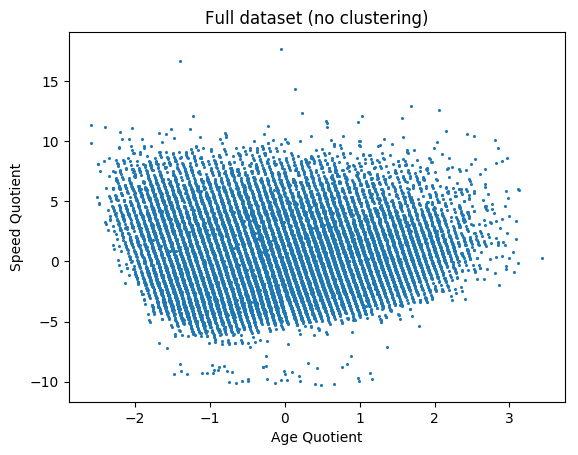

In [11]:
sns.reset_orig()
plt.scatter(pca_array[:,1], pca_array[:,0], s=1.5)
plt.xlabel('Age Quotient')
plt.ylabel('Speed Quotient')
plt.title("Full dataset (no clustering)")
plt.show()

It's worth noting two things about the speed-age relationship here.  First, though there the expected a very slight performance peak at just below average age (since that represents most people's athletic prime), the best performers are actually pretty widely spread across the age spectrum.  This isn't shocking since distance running is a sport that allows for a much more extended prime than sports that rely on explosiveness, which are harder on the joints.  However, the extent of the uniformity across age is surprising to me.

Second, the slowest runners tend to be a little younger than average.  This is probably due to the fact that 20-something-year-olds might casually decide to run a marathon without extensive training, whereas 15-year-olds or 60-year-olds would only participate if they were fairly serious.

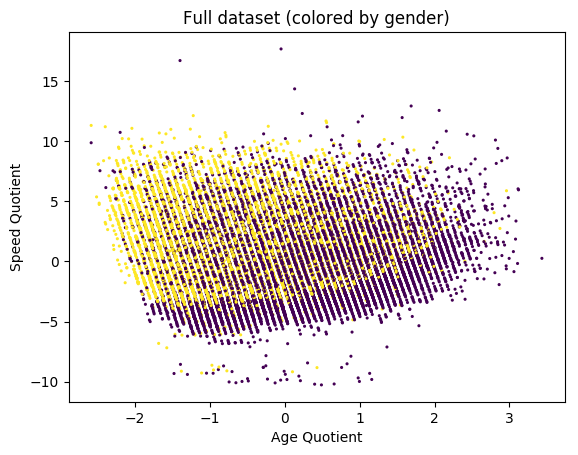

In [12]:
gender_labels = ['female' if label==1 else 'male' for label in results_df]
plt.scatter(pca_array[:,1], pca_array[:,0], s=1.5, c=results_df.gender)
plt.xlabel('Age Quotient')
plt.ylabel('Speed Quotient')
plt.title("Full dataset (colored by gender)")
plt.show()

Interesting: it looks like men are a bit faster at any given age (unsurprising), but also a bit younger overall.  Women start competing later but compete later into their lives.

### KNN

First, I'll look at KNN and Spectral to get a sense of how many clusters we should be looking for in cases for which we have to specify a number of clusters up-front.


In [13]:
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, SpectralClustering, DBSCAN
from show_silhouettes_alt import show_silhouettes # custom sklearn-example-based function in same directory
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples

Metrics for k=2:
   Inertia: 24871
   Silhouette: 0.519
   ARI: 0.998719723416832


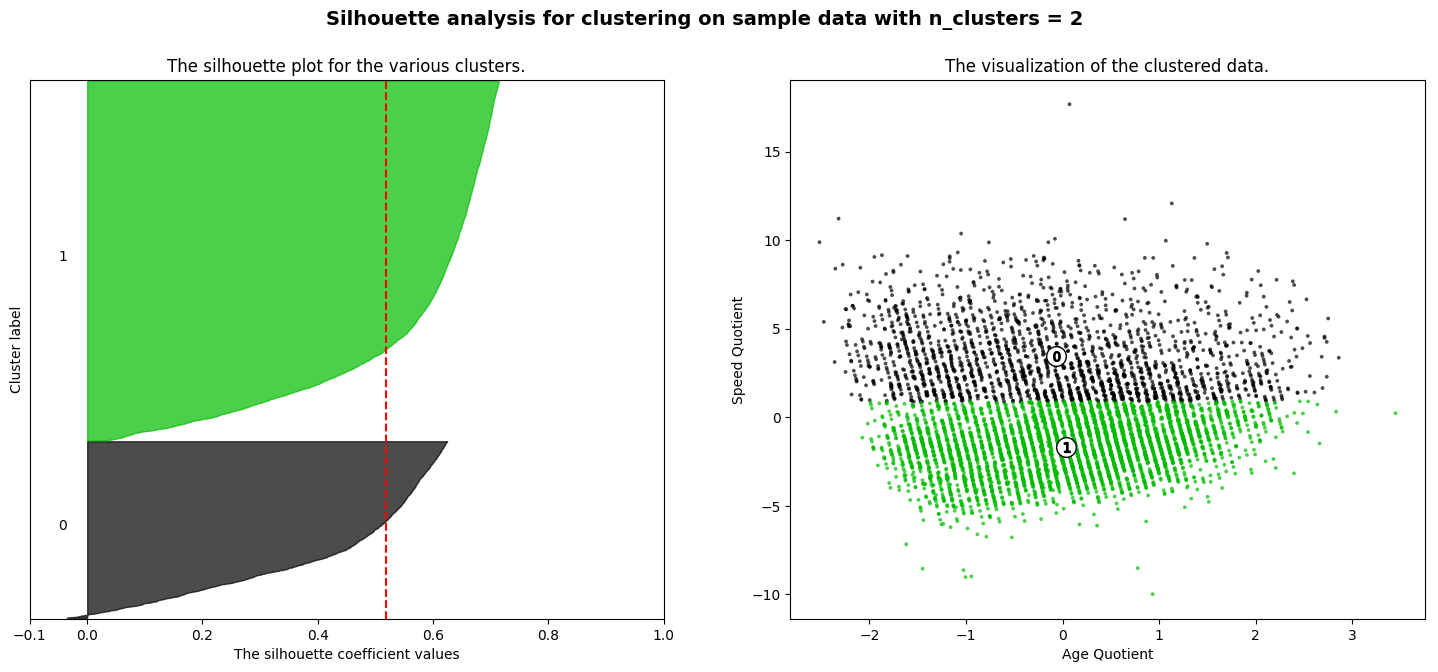

Metrics for k=3:
   Inertia: 15760
   Silhouette: 0.418
   ARI: 1.0


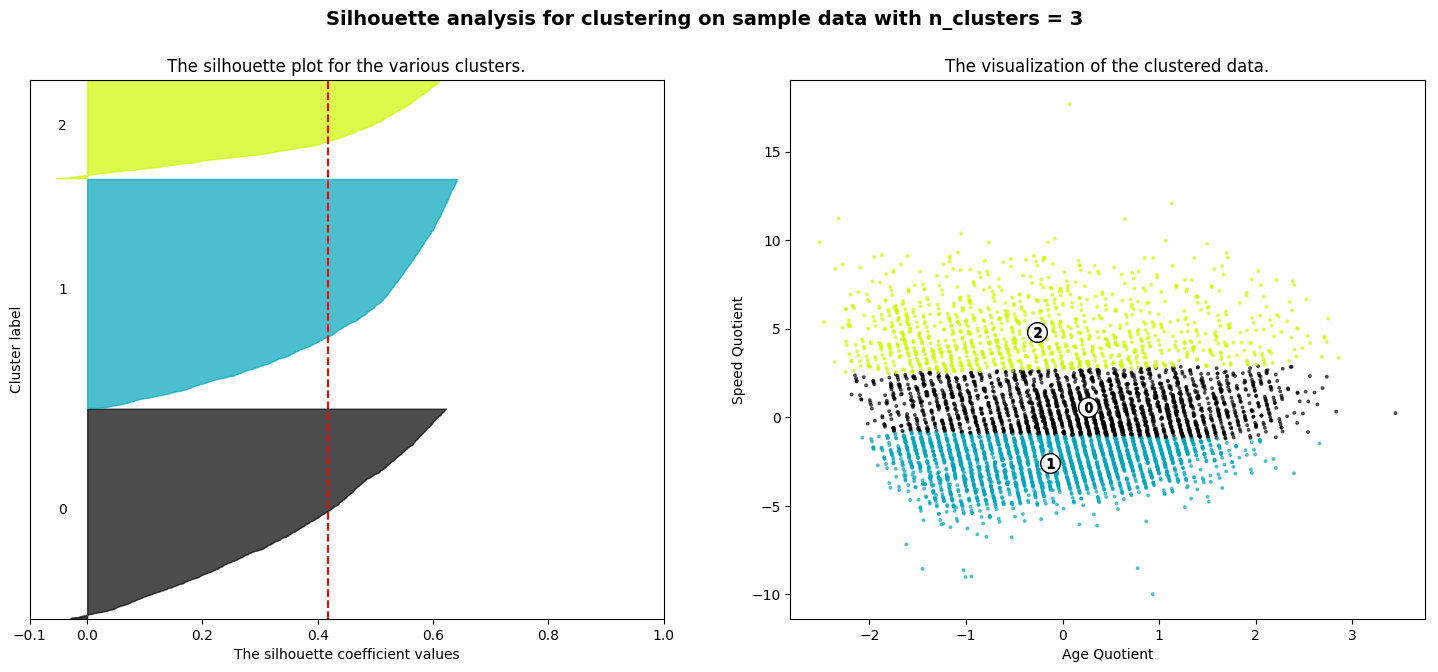

Metrics for k=4:
   Inertia: 12142
   Silhouette: 0.36
   ARI: 1.0


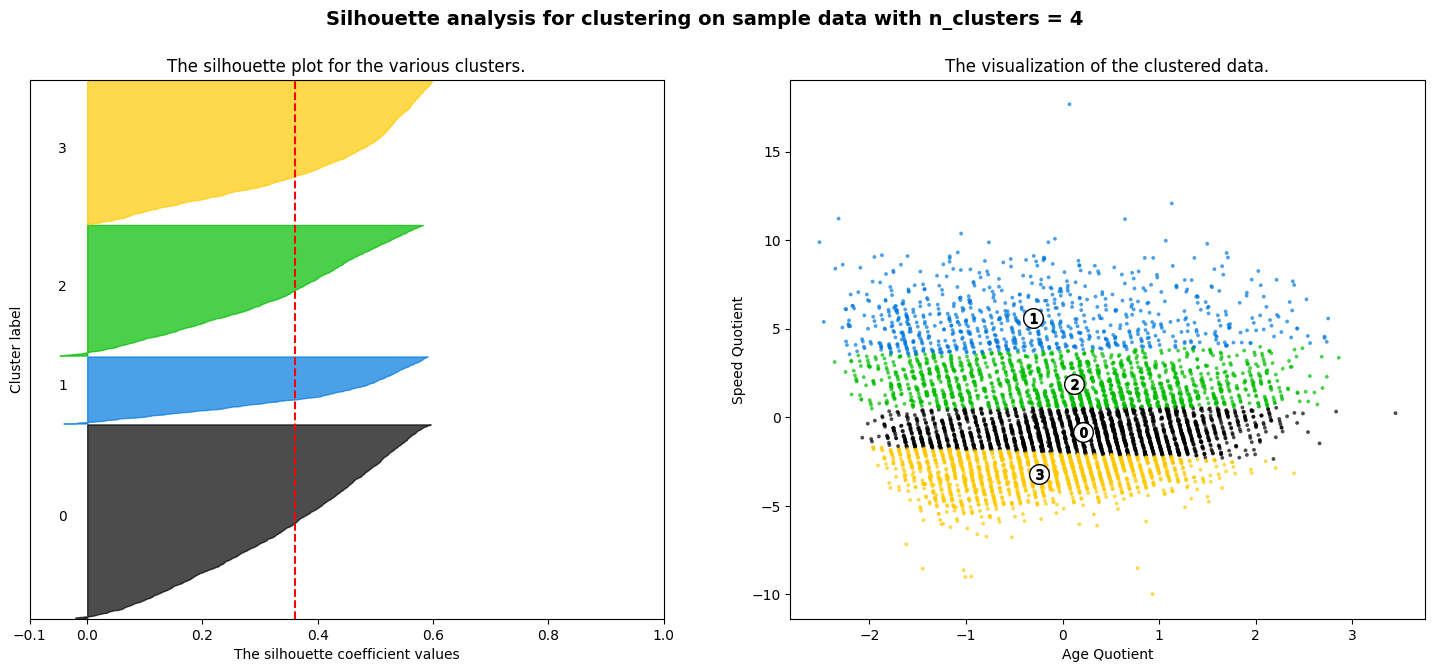

Metrics for k=5:
   Inertia: 10084
   Silhouette: 0.335
   ARI: 0.9976066226288758


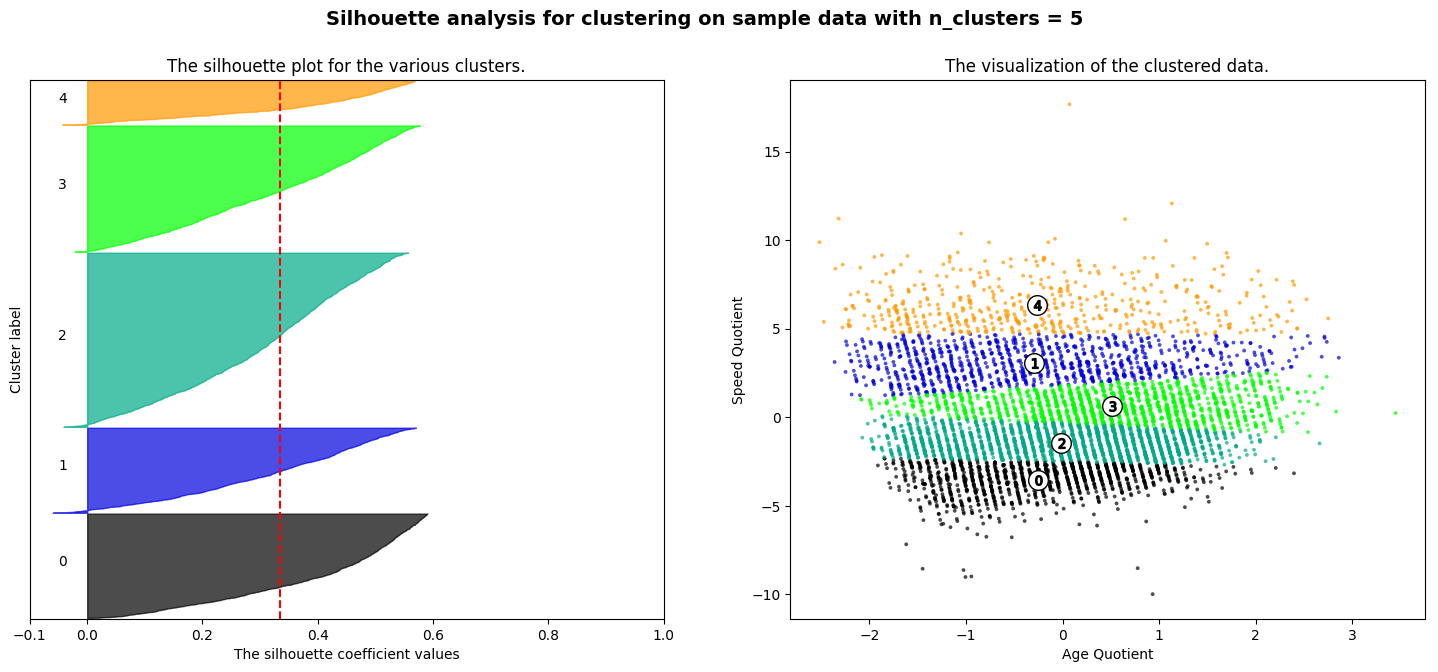

Metrics for k=6:
   Inertia: 8572
   Silhouette: 0.355
   ARI: 0.9864805930323698


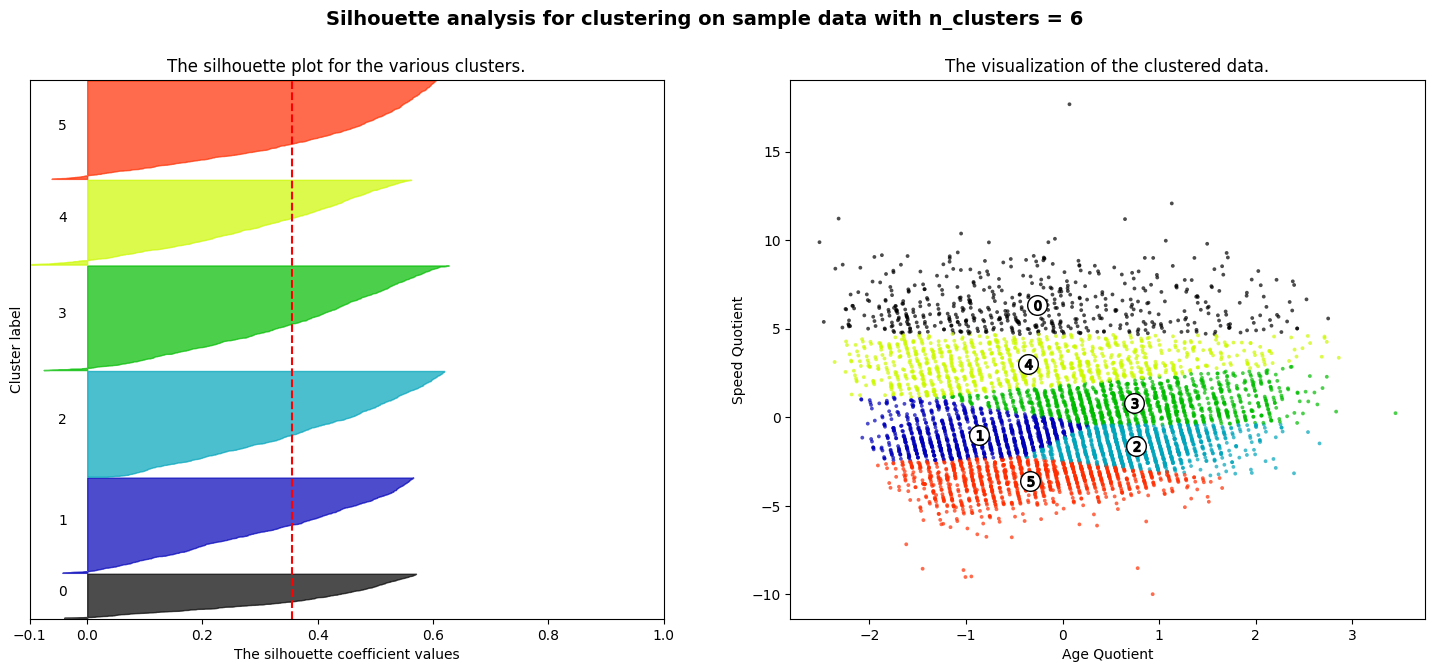

Metrics for k=7:
   Inertia: 7455
   Silhouette: 0.36
   ARI: 0.996535304500821


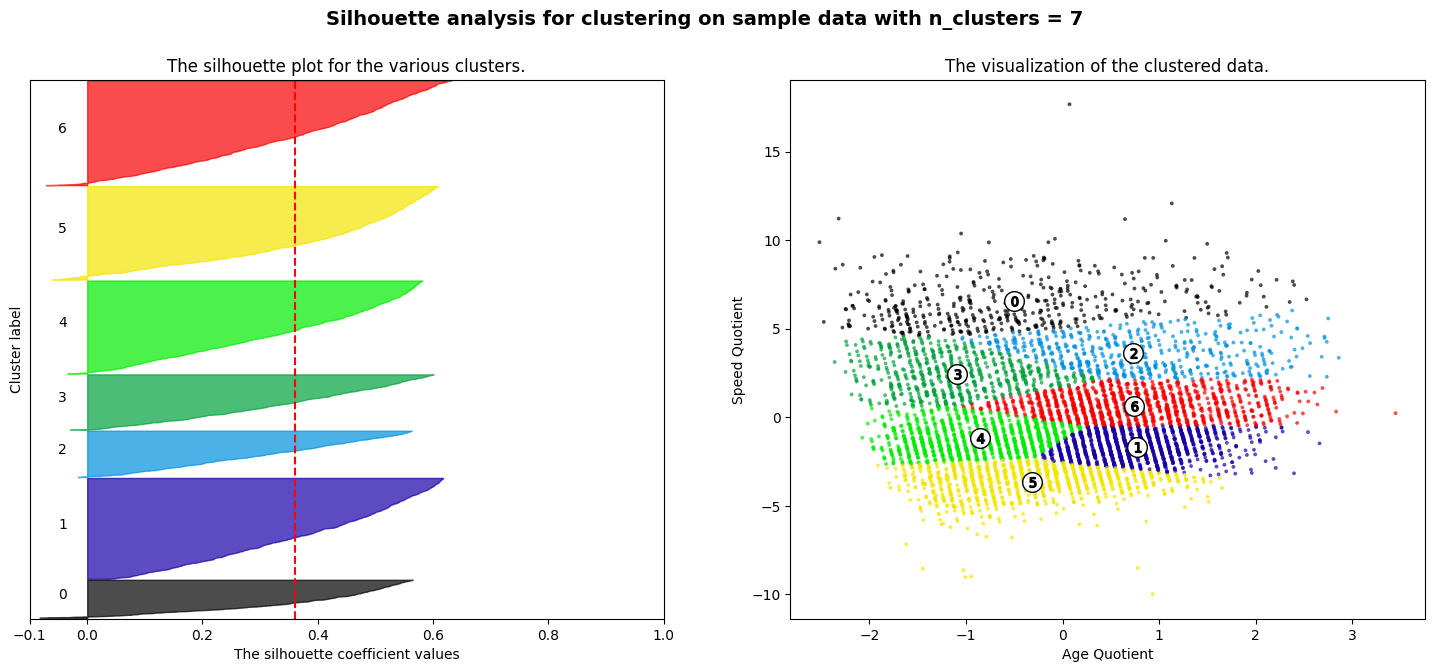

Metrics for k=8:
   Inertia: 6497
   Silhouette: 0.357
   ARI: 0.868896384268069


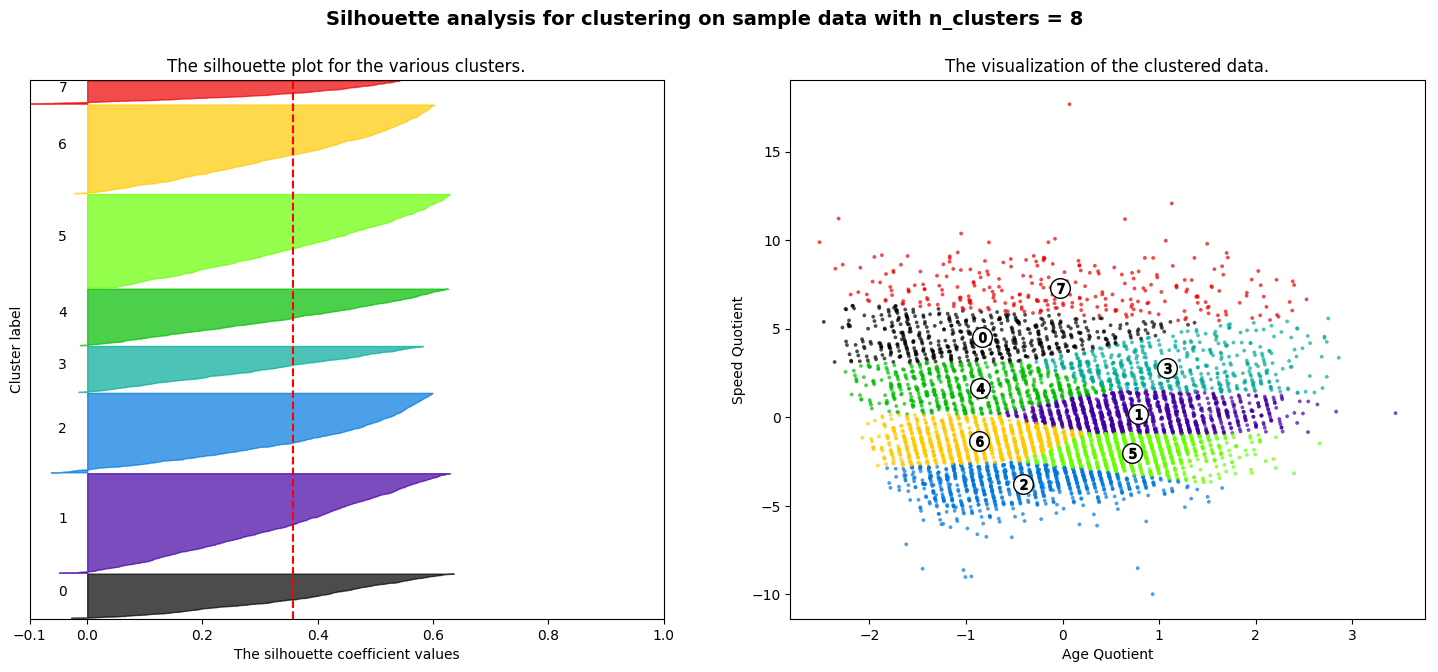

Metrics for k=9:
   Inertia: 5809
   Silhouette: 0.346
   ARI: 0.9789515114530788


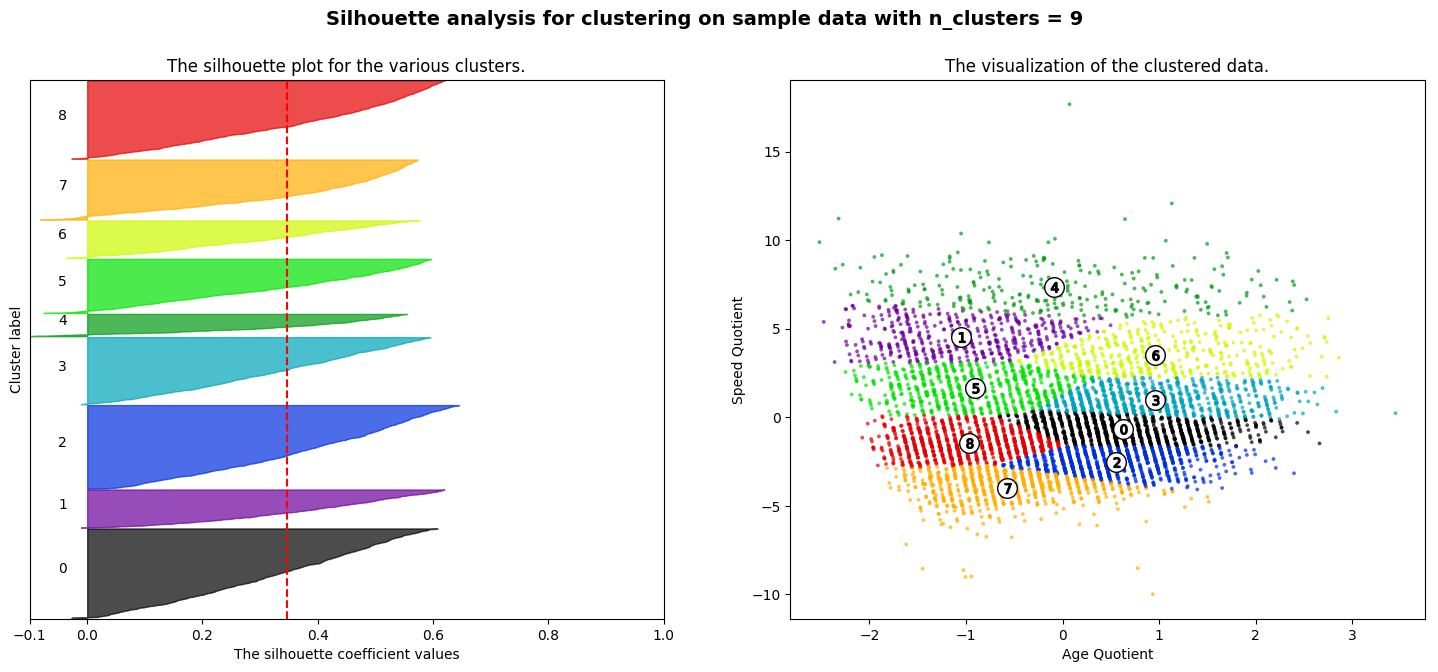

Metrics for k=10:
   Inertia: 5214
   Silhouette: 0.348
   ARI: 0.9626741364101037


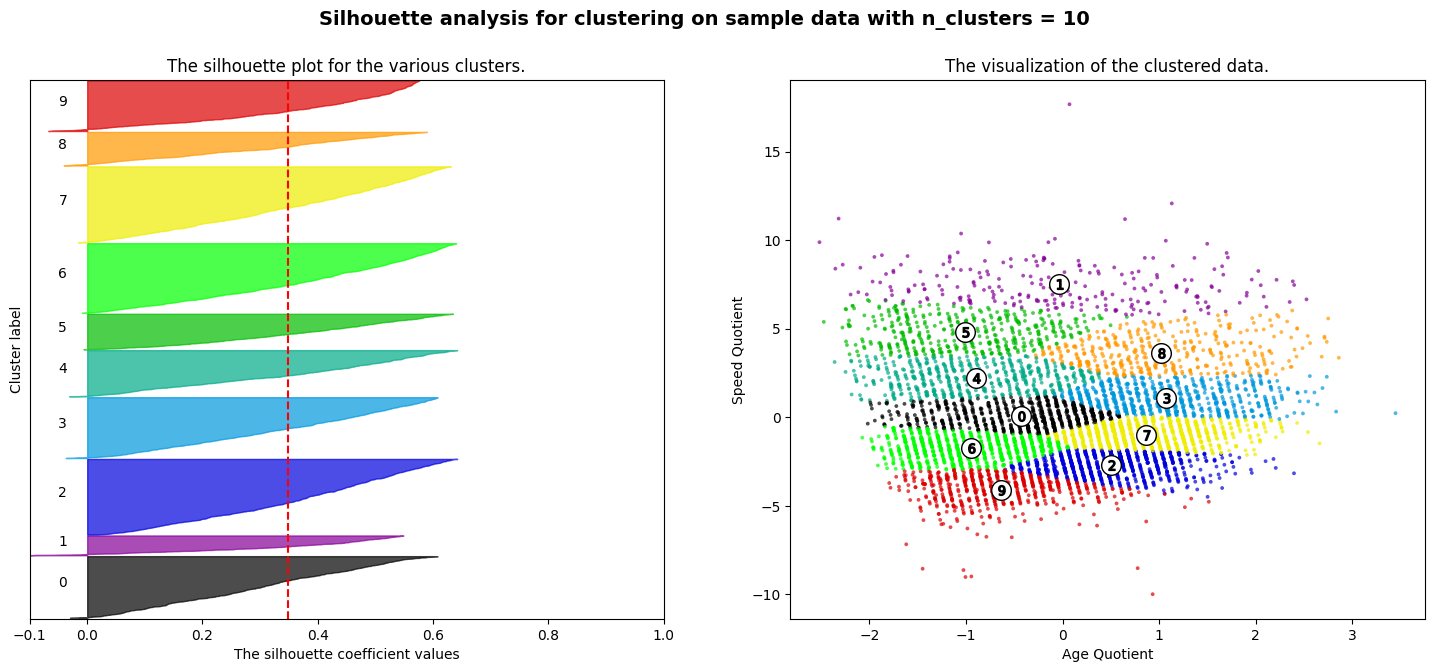

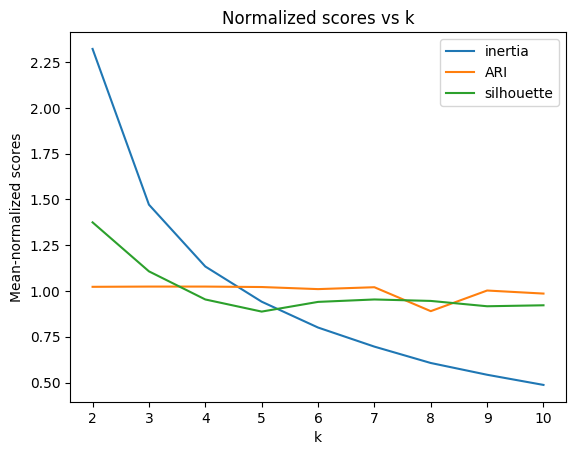

In [14]:
inertia_scores = []
ari_scores = []
silhouettes = []
for k in range(2,11):
    knn = KMeans(n_clusters=k, random_state=11)
    cluster_labels = knn.fit_predict(pca_sample)
    knn2 = KMeans(n_clusters=k, random_state=13)
    cluster_labels2 = knn2.fit_predict(pca_sample)
    ari = adjusted_rand_score(cluster_labels, cluster_labels2)
    ari_scores.append(ari)
    inertia_scores.append(knn.inertia_)
    silhouette = round(silhouette_score(pca_sample, cluster_labels), 3)
    silhouettes.append(silhouette)
    print("Metrics for k={}:".format(k))
    print("   Inertia:", int(round(knn.inertia_)))
    print("   Silhouette:", silhouette)
    print("   ARI:", ari)
    show_silhouettes(pca_sample, knn, k, cluster_labels, show_av_score=False)

    
plt.plot(range(2,11), inertia_scores / np.mean(inertia_scores), label='inertia')
plt.plot(range(2,11), ari_scores / np.mean(ari_scores), label='ARI')
plt.plot(range(2,11), silhouettes / np.mean(silhouettes), label='silhouette')
plt.title('Normalized scores vs k')
plt.xlabel("k")
plt.ylabel('Mean-normalized scores')
plt.legend()
plt.show()

These results suggest that the optimal number of clusters, at least for KNN clustering, is at least four (where the elbow of the inertia curve lies).  It probably makes the most sense to use either four, five, or eight clusters.  On the one hand, k=4 or k=5 would essentially divide the points into speed tiers.  On the ohter hand, k=8 divides the points into one positive speed-outlier group, one negative speed-outlier group, and three age-divided pairs of performance groups in between.  Both have good scores, so it's really a matter of preference and use.

We'll try these numbers with our other algorithms.   

### Mean-Shift

********* Quantile: 0.06 **********
Number of estimated clusters: 8
The average silhouette_score is : 0.291


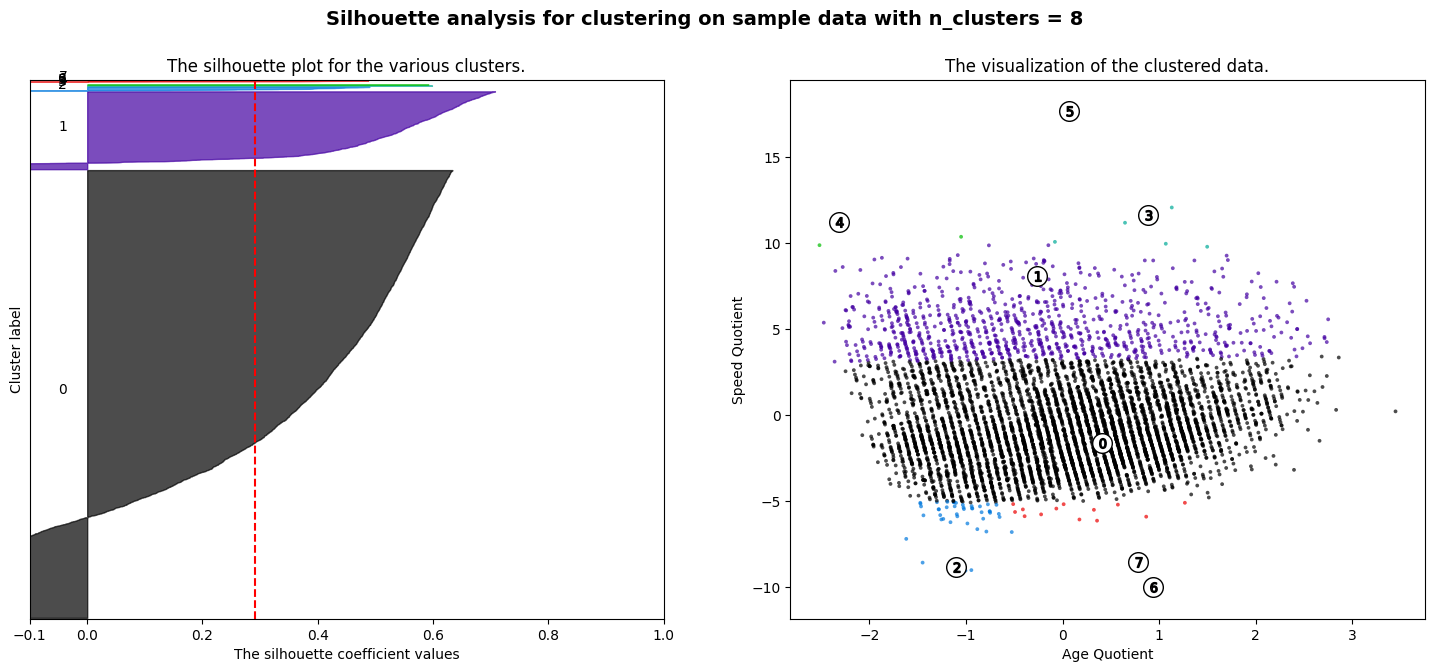

********* Quantile: 0.08 **********
Number of estimated clusters: 8
The average silhouette_score is : 0.215


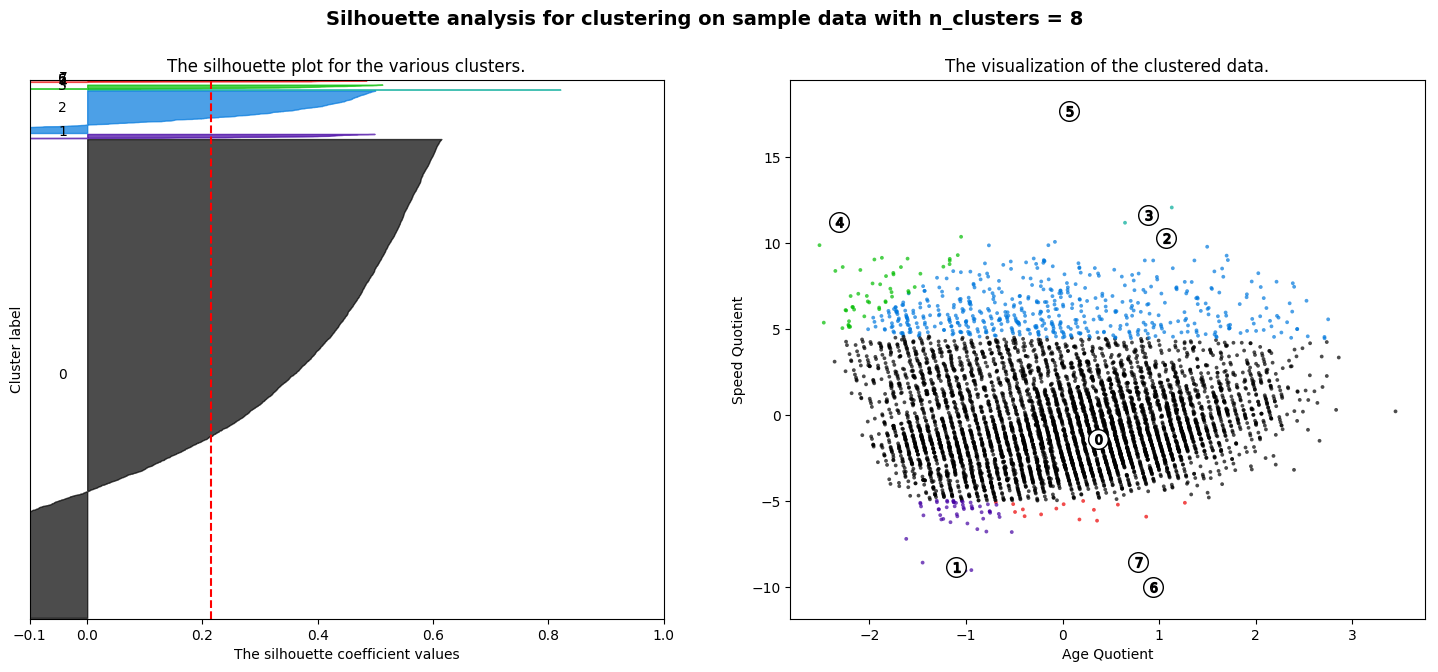

********* Quantile: 0.1 **********
Number of estimated clusters: 7
The average silhouette_score is : 0.225


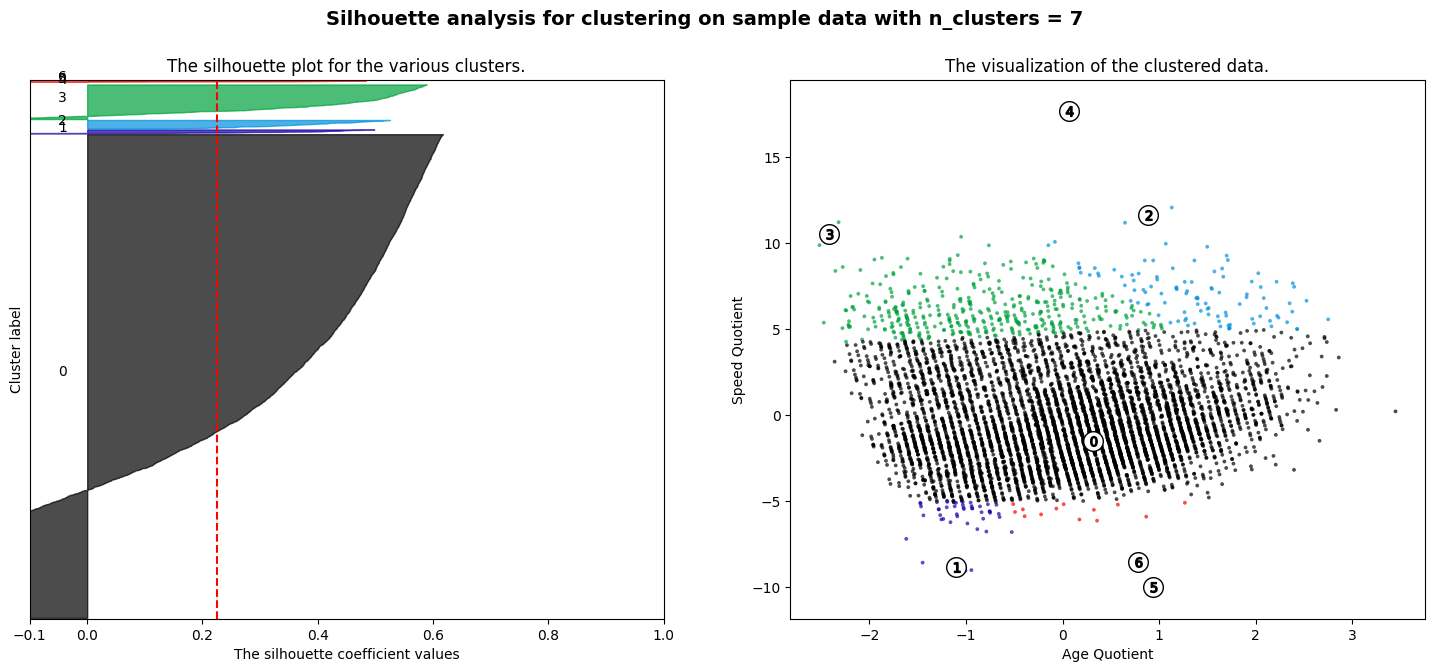

********* Quantile: 0.12 **********
Number of estimated clusters: 5
The average silhouette_score is : 0.268


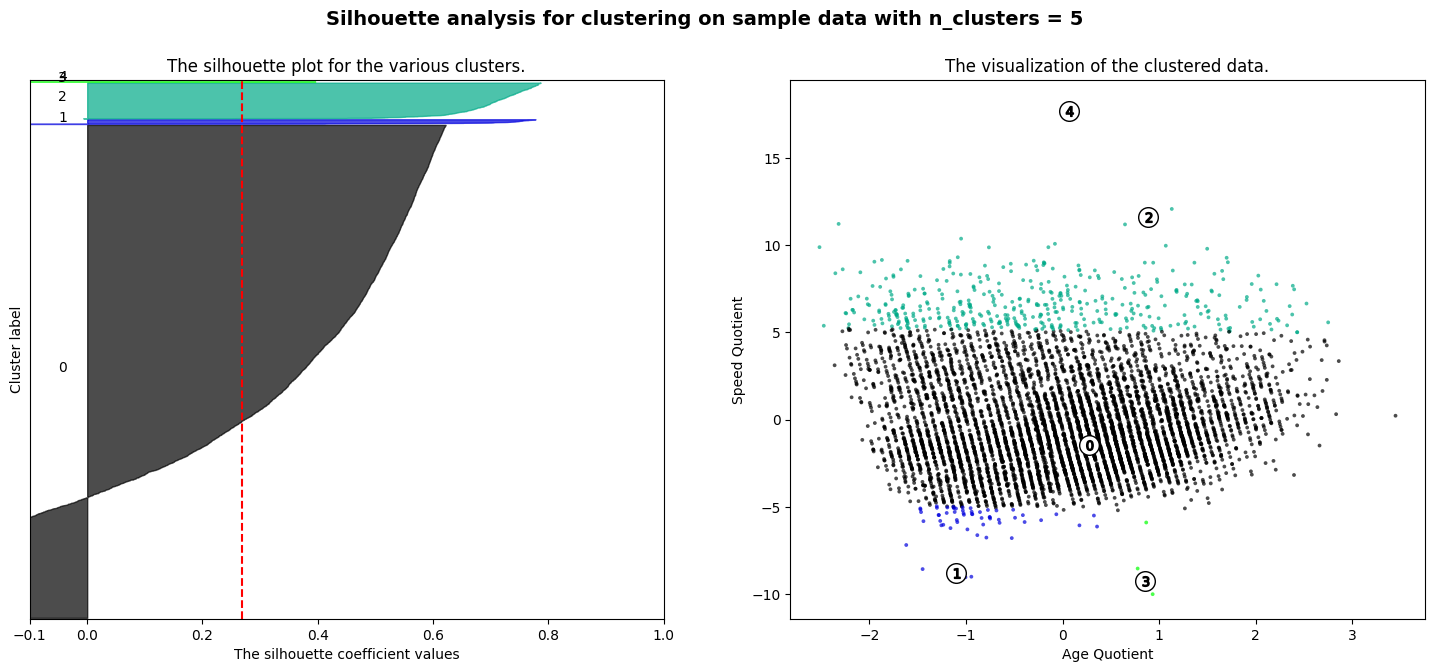

********* Quantile: 0.14 **********
Number of estimated clusters: 5
The average silhouette_score is : 0.277


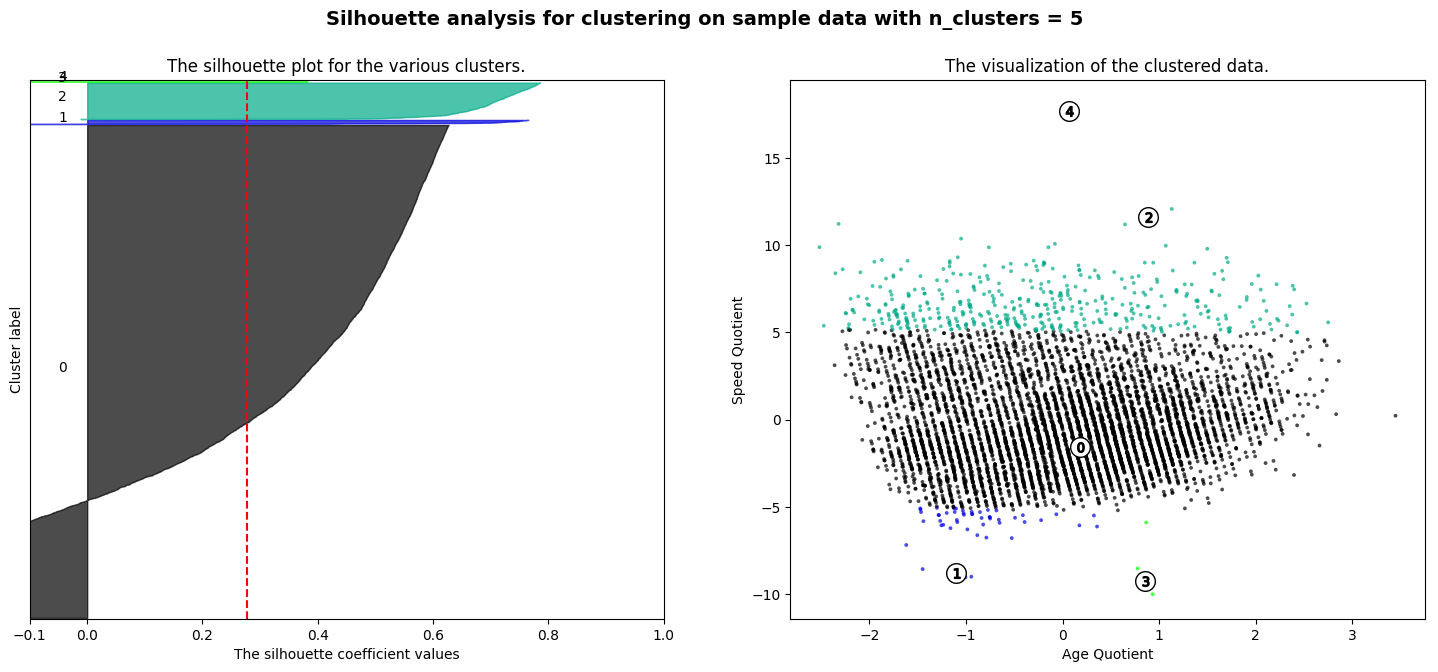

********* Quantile: 0.16 **********
Number of estimated clusters: 3
The average silhouette_score is : 0.257


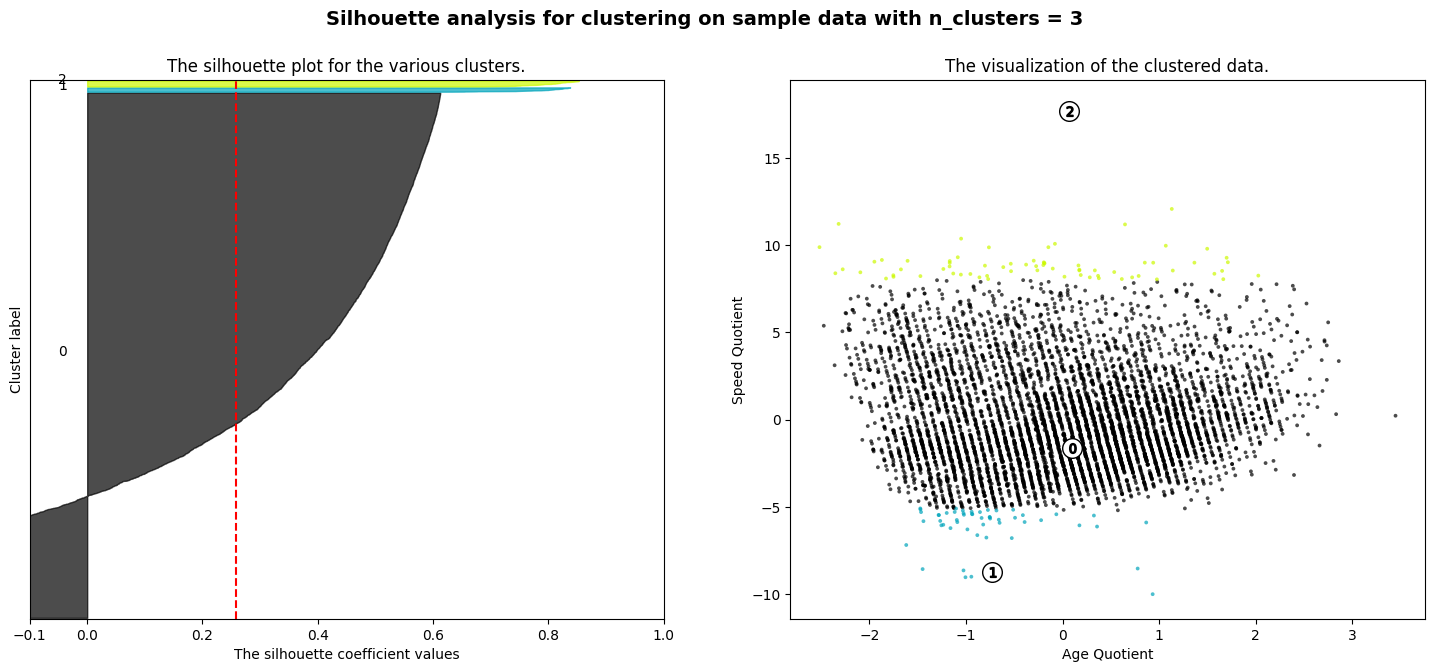

In [15]:
for q in [0.06, 0.08, 0.1, 0.12, 0.14, 0.16]:
    from sklearn.cluster import MeanShift, estimate_bandwidth
    bandwidth = estimate_bandwidth(pca_sample, quantile=q)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(pca_sample)
    labels = ms.labels_
    n_clusters = len(np.unique(labels))

    print("********* Quantile: {} **********".format(q))
    print("Number of estimated clusters: {}".format(n_clusters))
    show_silhouettes(pca_sample, ms, n_clusters, labels)

None of these clusters look very convincing: the silhouette scores aren't great, and the size discrepancies of the clusters are egregious, rendering the clustering unlikely to be very useful.

### Spectral


Metrics for k=2:
   Silhouette: 0.482
   ARI: 1.0


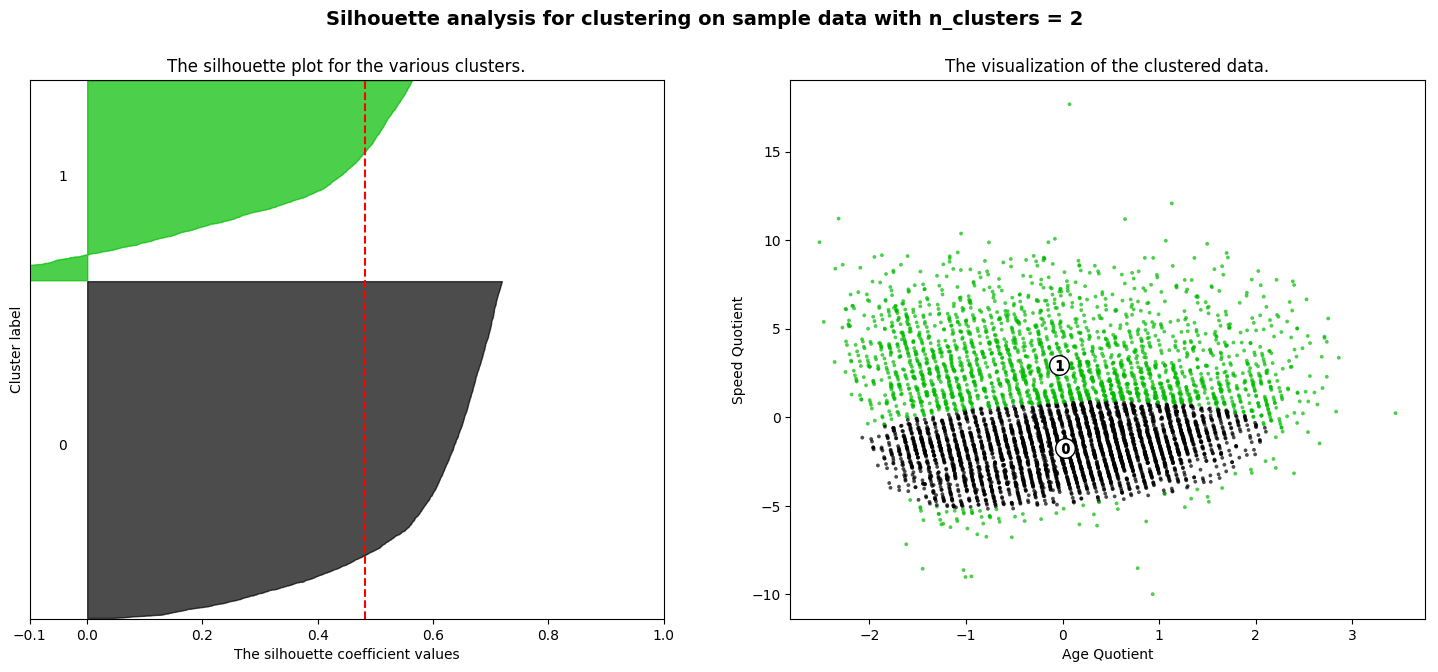

Metrics for k=3:
   Silhouette: 0.259
   ARI: 0.9976347984433077


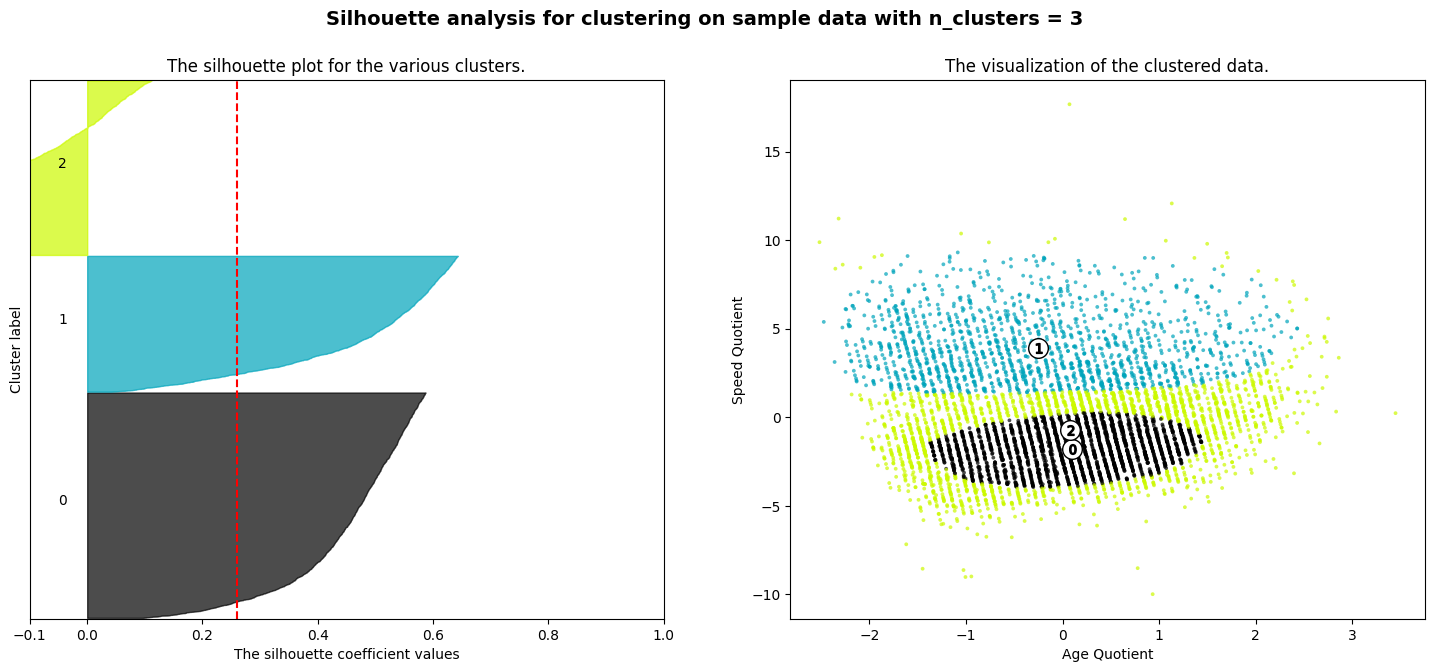

Metrics for k=4:
   Silhouette: 0.291
   ARI: 0.9991878438520017


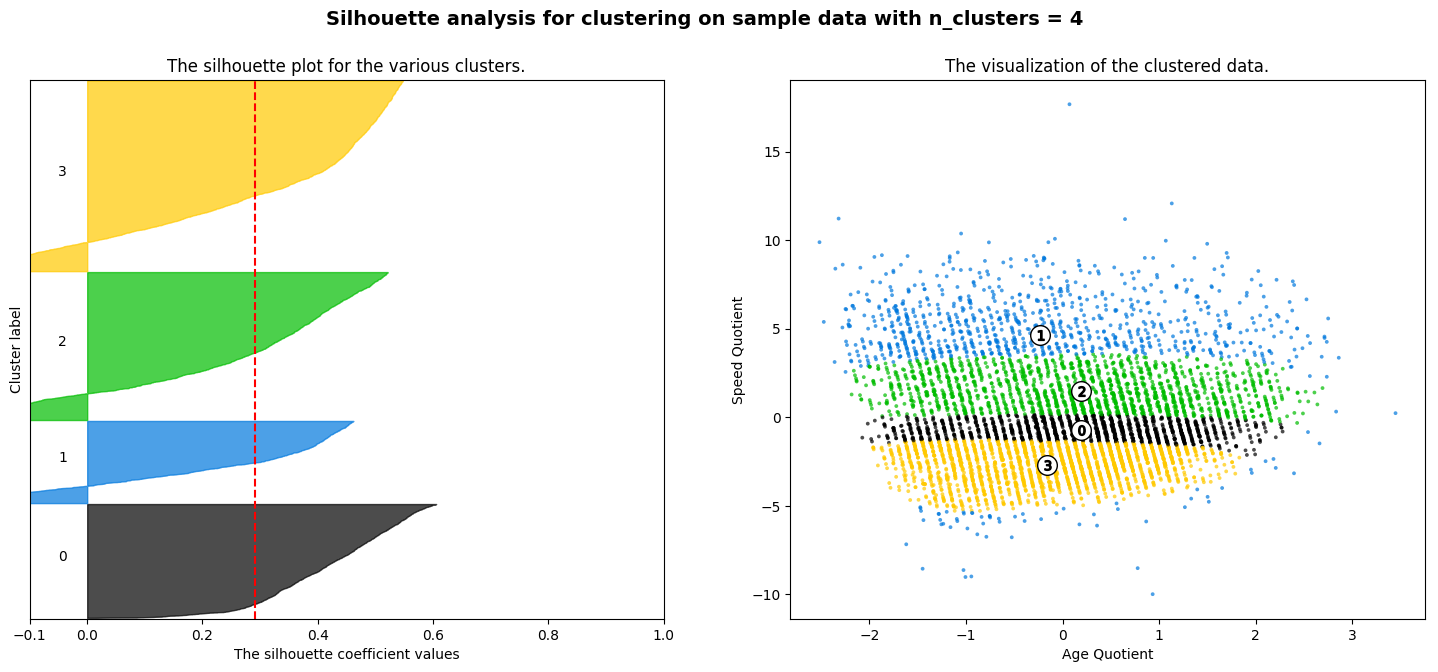

Metrics for k=5:
   Silhouette: 0.289
   ARI: 1.0


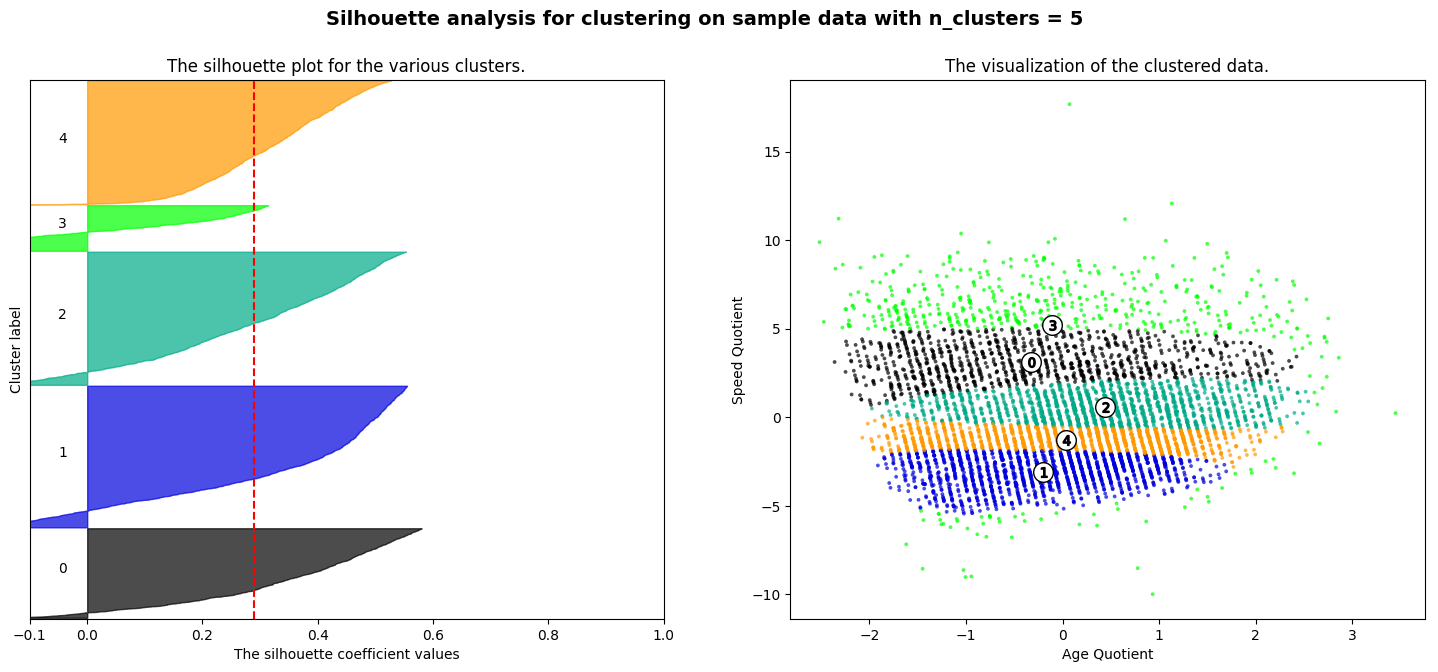

Metrics for k=6:
   Silhouette: 0.25
   ARI: 0.9929883622270941


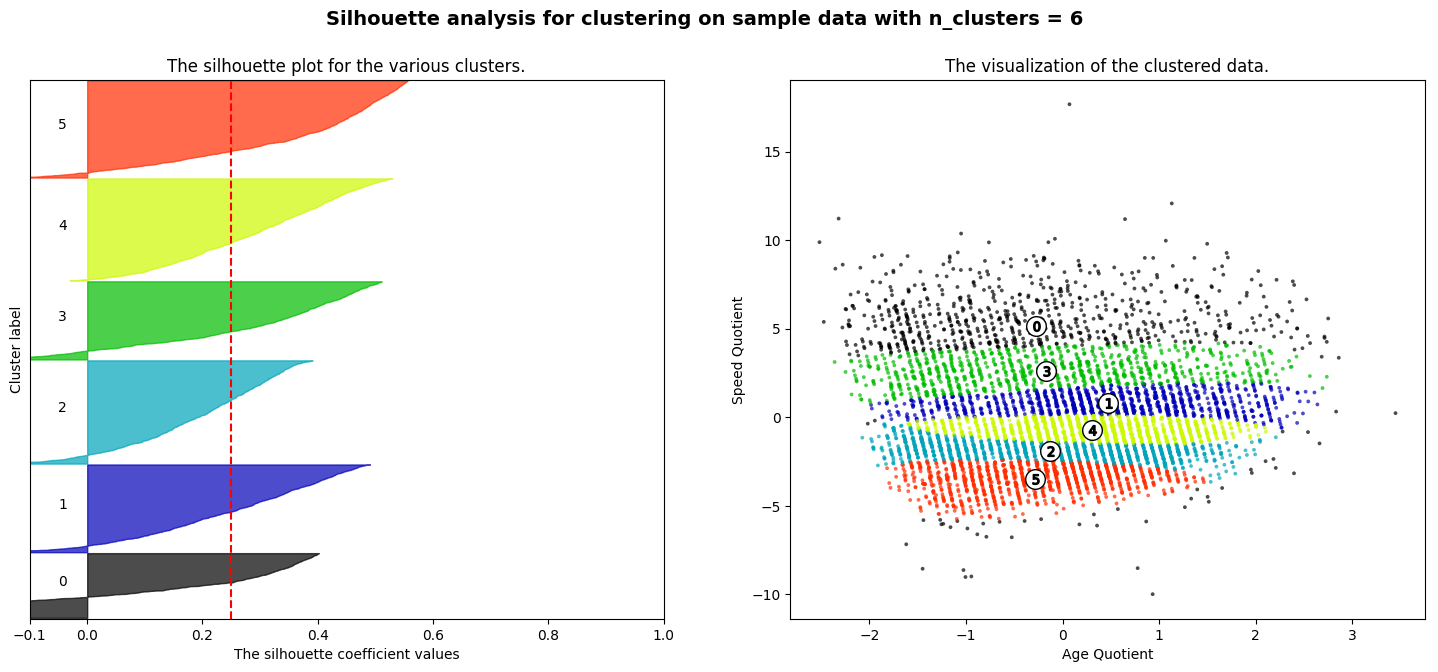

Metrics for k=7:
   Silhouette: 0.233
   ARI: 0.9963458365832215


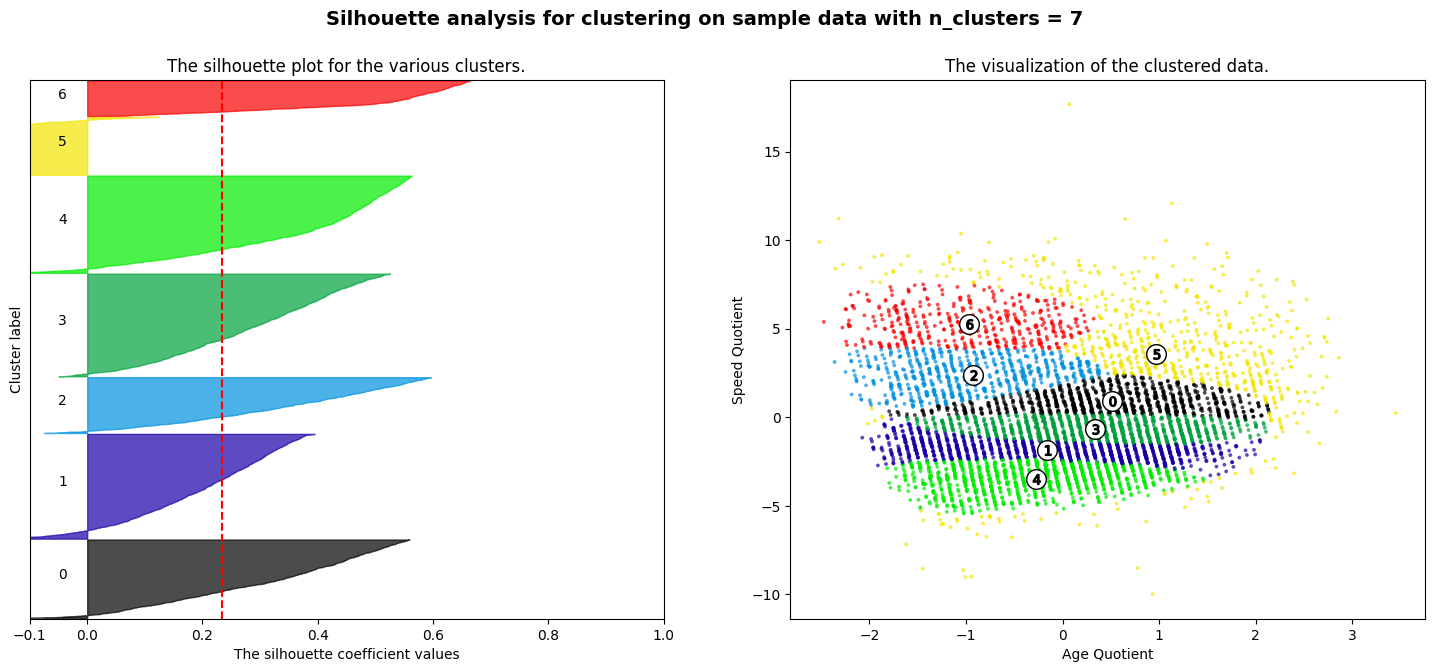

Metrics for k=8:
   Silhouette: 0.24
   ARI: 0.997511218194274


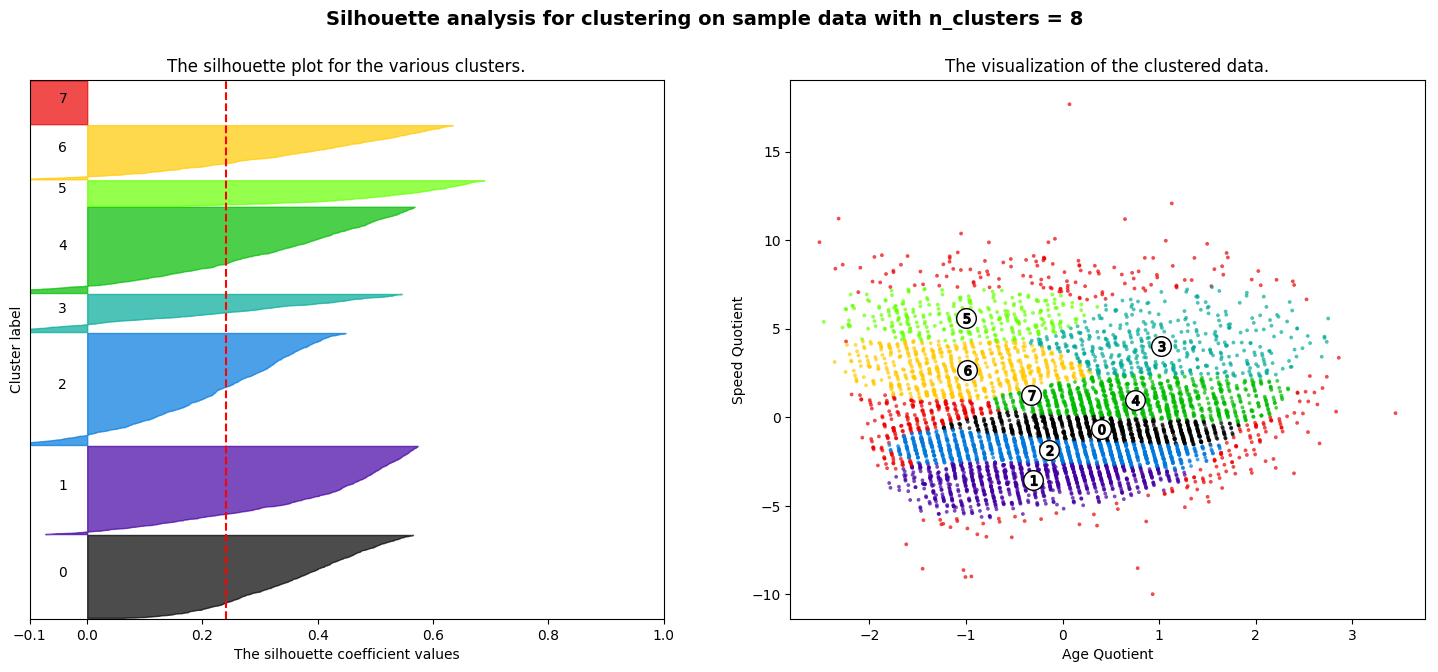

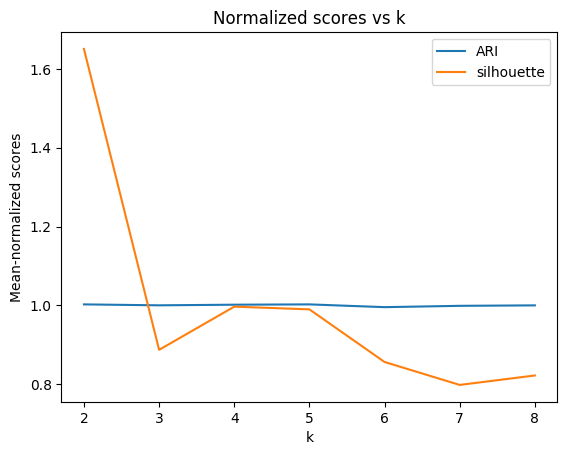

In [16]:
ari_scores = []
silhouettes = []
for k in range(2,9):
    sc = SpectralClustering(n_clusters=k, random_state=11)
    cluster_labels = sc.fit_predict(pca_sample)
    sc2 = SpectralClustering(n_clusters=k, random_state=13)
    cluster_labels2 = sc2.fit_predict(pca_sample)
    ari = adjusted_rand_score(cluster_labels, cluster_labels2)
    ari_scores.append(ari)
    silhouette = round(silhouette_score(pca_sample, cluster_labels), 3)
    silhouettes.append(silhouette)
    print("Metrics for k={}:".format(k))
    print("   Silhouette:", silhouette)
    print("   ARI:", ari)
    show_silhouettes(pca_sample, sc, k, cluster_labels, show_av_score=False)

# NOTE: consider adding one or two other sklearn metrics to this plot 
plt.plot(range(2,9), ari_scores / np.mean(ari_scores), label='ARI')
plt.plot(range(2,9), silhouettes / np.mean(silhouettes), label='silhouette')
plt.title('Normalized scores vs k')
plt.xlabel("k")
plt.ylabel('Mean-normalized scores')
plt.legend()
plt.show()

The severity of the shifts in silhouette scores here is exaggerated by the shortened y-axis (because there are no inertia scores to plot as there were in knn).  Nevertheless, there is a mild peak in silhouette score at k=4 and k=5.  It would probably make the most sense to choose k=5, which differentiates positive outliers better than k=4) and has a comparable silhouette score.  Beyond k=5, silhouette scores drop, and the clusters seem to be just adding more tiers without capturing any more insightful groupings or divisions.

### Affinity Propogation

In [17]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

af = AffinityPropagation(damping=0.7).fit(pca_minisample)

cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 60


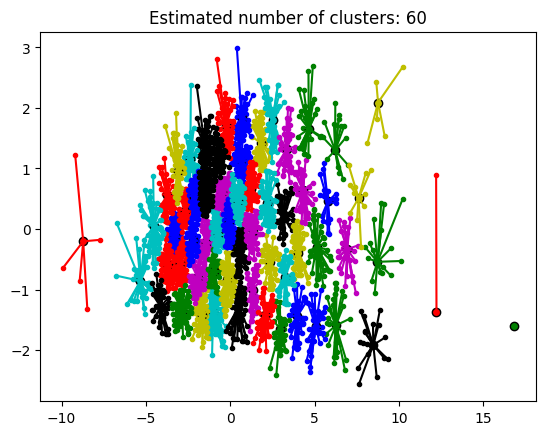

In [18]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = pca_minisample[cluster_centers_indices[k]]
    plt.plot(pca_minisample[class_members, 0], pca_minisample[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in pca_minisample[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

Well, this isn't looking very useful.  And we don't have easy parameters to adjust as with the other techniques.

### HDBSCAN


Predicted number of clusters: 4
elapsed time: 0.0 minutes


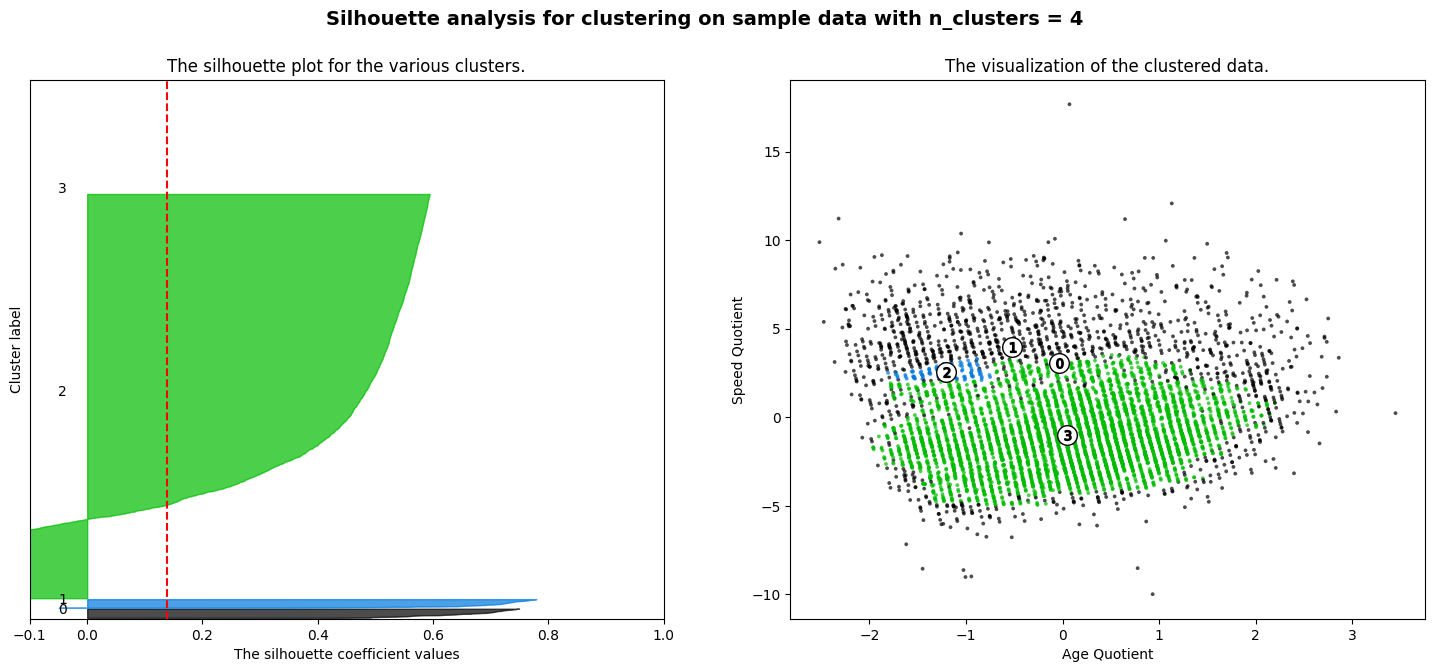

In [19]:
import hdbscan

start = time()

hdb_clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=3, cluster_selection_method='eom')
cluster_labels = hdb_clusterer.fit_predict(pca_sample)
n_clusters = len(np.unique(cluster_labels))

print("Predicted number of clusters:", n_clusters)
print("elapsed time:", round((time()-start)/60, 1), "minutes")

show_silhouettes(pca_sample, hdb_clusterer, n_clusters, cluster_labels, show_av_score=False)

On this dataset, hdbscan is basically functioning as an outlier detection algorithm.  It selects the core chunk of data as one category, leaves the broadly-defined outliers as unlabeled (pictured as black here), and picks out a couple other tiny groups within the data (it's hard to say if they have any significance).  This could be useful for cetrain purposes, but it's not especially effective as a traditional clustering algorithm.

# Conclusions

The clustering techniques that work best on this dataset are k-means clustering and spectral clustering.  The PCA that was required to prepare the dataset revealed that the two essential characteristics of the data are speed/perfomance and age.  

The clustering techniques themselves reveal that the data naturally groups into five tiers of performers (or eight groups, if you want to make some age distinctions as well).  These tiers consist of negative outliers, positive outliers, and three common closer-to-average levels of performance.  If we wish to categorize runners based on the data, we have a fairly logical set of patterns that the runners fall into.

We can also use a lower-K spectral clustering or HDBSCAN to separate all the outliers (positive and negative performance, or unusually old or young) from the core group.

Overall, clustering here is actually not as useful as in many other circumstances.  The reason is that the data is nearly all based on age and speed.  You could get essentially the same results from just plotting age and speed and doing a solid analysis on the results; the clustering algorithms just provide some nice detail in the divisions.  Computerized clustering is more useful in scenarios with many independent variables, where humans cannot easily conceptualize similarity and categorization on their own.